# Data scaling

### Importing modules, loading dataset and breaking it into X and y

In [96]:
# NumPy
import numpy as np

# Dataframe operations
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Models
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.linear_model import Perceptron
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction

# GridSearchCV
from sklearn.model_selection import GridSearchCV

%matplotlib inline

# Loading data:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

# Loading REAL data:
#real_df = pd.read_excel('real_data.xls')
#y_real = real_df['survived'][891:]
real_df = pd.read_csv('real_data_submission.csv')
y_real = real_df['Survived']

## 0. Загрузка чистых X и y 

In [97]:
X = train_df.drop('Survived', 1)
y = train_df['Survived']

## 1. Шкалирование в [0, 1]

In [65]:
X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)

## 2. Стандартизация

In [98]:
# Standardizing ALL features:
X = StandardScaler().fit_transform(X)

# Standardizing all but Categorical features:
# FORMULA :: dfTest[['A', 'B']] = scaler.fit_transform(dfTest[['A', 'B']])
# temp = train_df
# temp[['Pclass','Age','Family_Size']] = StandardScaler().fit_transform(train_df[['Pclass','Age','Family_Size']])
# X = temp.drop('Survived', 1)
# y = temp['Survived']

## Оценка на группе различных моделей

In [99]:
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes',
             'Random Forest', 'Multi-layer Perceptron']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=8),
        DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100), MLPClassifier()]
for i in models:
    model = i
    cv_result = cross_val_score(model, X, y, cv = kfold, scoring = "accuracy")
    cv_result = cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe = pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe

,CV Mean,Std
Linear Svm,0.832747,0.028307
Radial Svm,0.847341,0.036033
Logistic Regression,0.840624,0.026514
KNN,0.839501,0.033748
Decision Tree,0.824906,0.024262
Naive Bayes,0.787940,0.046632
Random Forest,0.836167,0.030050
Multi-layer Perceptron,0.848464,0.033125


## Оценка на ансамблях

In [65]:
ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=8)),
                                              ('RBF',svm.SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                                              ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                              ('svm',svm.SVC(kernel='linear',probability=True))
                                             ], 
                       voting='soft').fit(X, y)
cross=cross_val_score(ensemble_lin_rbf, X, y, cv = 10,scoring = "accuracy")
print('Ensamble CV score score =',cross.mean())

Ensamble CV score score = 0.849597094541


In [66]:
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result=cross_val_score(ada,X,y,cv=10,scoring='accuracy')
print('AdaBoost CV score =',result.mean())

AdaBoost CV score = 0.844066791511


### KNN
Для стандартизированных данных лучшие параметры KNN:<br>
**0.858585858586**<br>
KNeighborsClassifier(algorithm='auto', leaf_size=6, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')

In [27]:
n_neighbors = list(range(1,30,1))
algo = ['auto','ball_tree','kd_tree'] # used; best seems to be auto
weights = ['uniform', 'distance'] # used
leaf_size = list(range(1,50,5)) # used;
hyperparams = {'n_neighbors': n_neighbors, 'weights': weights}
gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, cv=10)
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 58 candidates, totalling 580 fits
0.803591470258
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='distance')


[Parallel(n_jobs=1)]: Done 580 out of 580 | elapsed:    9.2s finished


### LogisticRegression

In [143]:
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
C = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.1, 1.3, 1.5] # C=0.3?
tol = [0.000001, 0.00001, 0.0001, 0.001,0.01,0.1] # C=0.1?
hyperparams = {'solver': solver, 'tol': tol, 'C':C}
gd=GridSearchCV(estimator = LogisticRegression(), param_grid = hyperparams, verbose=True, cv=10)
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits
0.846240179574
LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.1,
          verbose=0, warm_start=False)


[Parallel(n_jobs=1)]: Done 2700 out of 2700 | elapsed:   21.1s finished


<br>
<br>
<br>
## Проверка группы моделей на РЕАЛЬНЫХ данных

In [100]:
# -------------------------------------------------
X_test = test_df
X_test = StandardScaler().fit_transform(X_test)
# -------------------------------------------------

kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
out_of_sample_score = []
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes',
             'Random Forest', 'Perceptron', 'Multi-layer Perceptron']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=8),
        DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100), 
        Perceptron(max_iter=5), MLPClassifier()]
for i in models:
    model = i
    cv_result = cross_val_score(model, X, y, cv = kfold, scoring = "accuracy")
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
    # Real out of sample accuracy:
    model.fit(X, y)
    y_pred = model.predict(X_test)
    out_of_sample_score.append(metrics.accuracy_score(y_real, y_pred))
    
new_models_dataframe = pd.DataFrame({'CV Mean':xyz,'Std':std, 'Accuracy on real data': out_of_sample_score},
                                    index=classifiers)
new_models_dataframe

,Accuracy on real data,CV Mean,Std
Linear Svm,0.736842,0.832747,0.028307
Radial Svm,0.772727,0.847341,0.036033
Logistic Regression,0.765550,0.840624,0.026514
KNN,0.770335,0.839501,0.033748
Decision Tree,0.724880,0.826017,0.028644
Naive Bayes,0.746411,0.787940,0.046632
Random Forest,0.739234,0.832797,0.028009
Perceptron,0.751196,0.773483,0.062266
Multi-layer Perceptron,0.777512,0.851835,0.029286


## Проверка выбрaнной лучшей модели на РЕАЛЬНЫХ данных
Здесь проверяется генерализация (обобщающая способность) - насколько хорошо модель работает с вневыборочными данными.

In [90]:
X_test = test_df
X_test = StandardScaler().fit_transform(X_test)

best_model = KNeighborsClassifier(algorithm='auto', leaf_size=6, metric='minkowski', 
                                  metric_params=None, n_jobs=1, n_neighbors=6, p=2, 
                                  weights='uniform')

best_model.fit(X, y)
y_pred = best_model.predict(X_test)

metrics.accuracy_score(y_real, y_pred)

0.77272727272727271

In [87]:
best_model = LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True, 
                                intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                                penalty='l2', random_state=None, solver='sag', tol=0.1,
                                verbose=0, warm_start=False)
#best_model = svm.SVC(kernel='rbf')
#best_model = RandomForestClassifier(n_estimators=100)

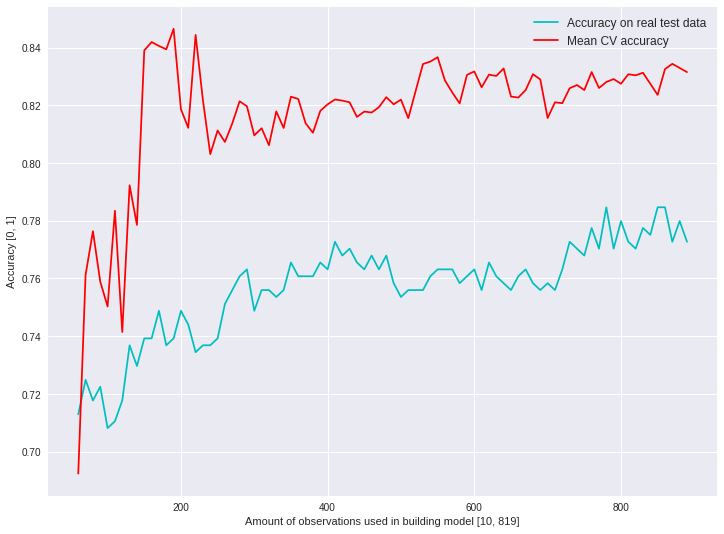

In [91]:
# Data partitions will look like [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, ... , 890].
# This depicts how many examples do we take from training set to fit our model.
data_partitions = list(range(2, 10))
for i in range(10, 891, 10):
    data_partitions.append(i)
data_partitions = list(range(60, 891, 10))

# Random shuffling!
from sklearn.utils import shuffle
Xxx, yyy = shuffle(X, y)

scores = []
cv_results = []
for n_examples in data_partitions:
    # X_temp, y_temp = shuffle(X[:n_examples]), shuffle(y[:n_examples])
    X_temp, y_temp = X[:n_examples], y[:n_examples]
    # X_temp, y_temp = Xxx[:n_examples], yyy[:n_examples]
    best_model.fit(X_temp, y_temp)
    y_pred = best_model.predict(X_test)
    # Measuring real data performance:
    score = metrics.accuracy_score(y_real, y_pred)
    scores.append(score)
    # Measuring CV score:
    cv_result = cross_val_score(best_model, X_temp, y_temp, cv = 10, scoring = "accuracy")
    cv_results.append(cv_result.mean())

#plt.plot(data_partitions, scores, 'c--', label='y = x - 2')
#plt.show()

real_data_performance,   = plt.plot(data_partitions, scores, 'c', label='Accuracy on real test data')
cv_measured_performance, = plt.plot(data_partitions, cv_results, 'r', label='Mean CV accuracy')

# Setting up a legend and tuning figure size: 
plt.rcParams["figure.figsize"] = [12, 9]
plt.legend(handles=[real_data_performance, cv_measured_performance], prop={'size': 12})
plt.xlabel("Amount of observations used in building model [10, 819]")
plt.ylabel("Accuracy [0, 1]")
plt.show()

#print(cv_results)

<br>
<br>
<br>
## Применение модели и запись данных

In [128]:
X_test = test_df
X_test = StandardScaler().fit_transform(X_test)

best_model = KNeighborsClassifier(algorithm='auto', leaf_size=6, metric='minkowski', 
                                  metric_params=None, n_jobs=1, n_neighbors=6, p=2, 
                                  weights='uniform')

best_model.fit(X, y)
y_pred = best_model.predict(X_test)

"""
# WRITING DATA TO SUBMISSION FILE #
test_csv_df = pd.read_csv("test.csv")
submission = pd.DataFrame({
        "PassengerId": test_csv_df["PassengerId"],
        "Survived": y_pred})
submission.to_csv('submission.csv', index=False)
"""